In [19]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 1 on shared node
sys.path.append('../../')
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Flatten, Reshape, Concatenate, Add
from tensorflow.keras.models import Model
from medl.models.random_effects import DenseRandomEffects

In [11]:
# Trained model weights
MEWEIGHTS = '/archive/bioinformatics/DLLab/KevinNguyen/results/MEDL/gbm_segmentation_mixedeffects_20210105/final_test/final_weights.h5'

In [12]:
def unet_mixedeffects(random_effects_size, pretrained_weights=None, input_size=(256,256,1), random_int=True, random_slope=False):
    inputs = Input(input_size)
    inputsRE = Input(random_effects_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Insert random effects layers
    latent_shape = np.ones((3,))
    latent_shape[:2] = np.array(input_size[:-1]) * (0.5 ** 4)
    if random_int & (not random_slope):
        reInt = DenseRandomEffects(int(np.product(latent_shape)), name='RE_int')(inputsRE)
        reIntFilt = Reshape(latent_shape.astype(int))(reInt)
        mixed = Concatenate(axis=-1)([drop5, reIntFilt])    
    if random_slope:
        raise NotImplementedError('random slope is not implemented yet')
        # reSlope = something
        # reSlopeFilt = Reshape(latent_shape)(reSlope)
        # mixed = Concatenate(axis=-1)([mixed, reSlopeFilt])

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(mixed))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model([inputs, inputsRE], conv10)

    # model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [14]:
model = unet_mixedeffects((294,), pretrained_weights=MEWEIGHTS, input_size=(240, 240, 4), random_int=True)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 240, 240, 64) 2368        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 240, 240, 64) 36928       conv2d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 120, 120, 64) 0           conv2d_59[0][0]                  
_______________________________________________________________________________________

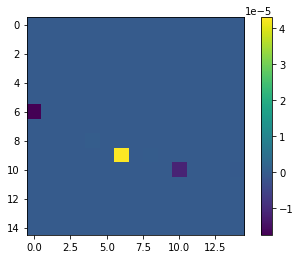

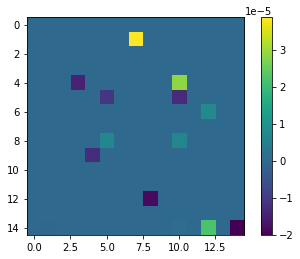

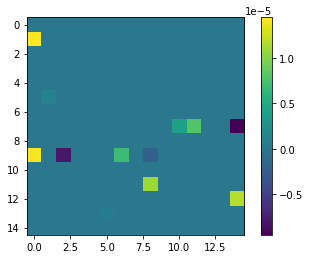

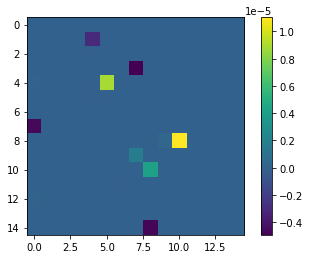

In [20]:
arrRandomWeights = model.get_layer('RE_int').weights[0].numpy()
for i in range(4):
    plt.imshow(arrRandomWeights[i,].reshape(15, 15), cmap='viridis')
    plt.colorbar()
    plt.show()